In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

import matplotlib.pyplot as plt

## LSTM (Long Short Term Memory)
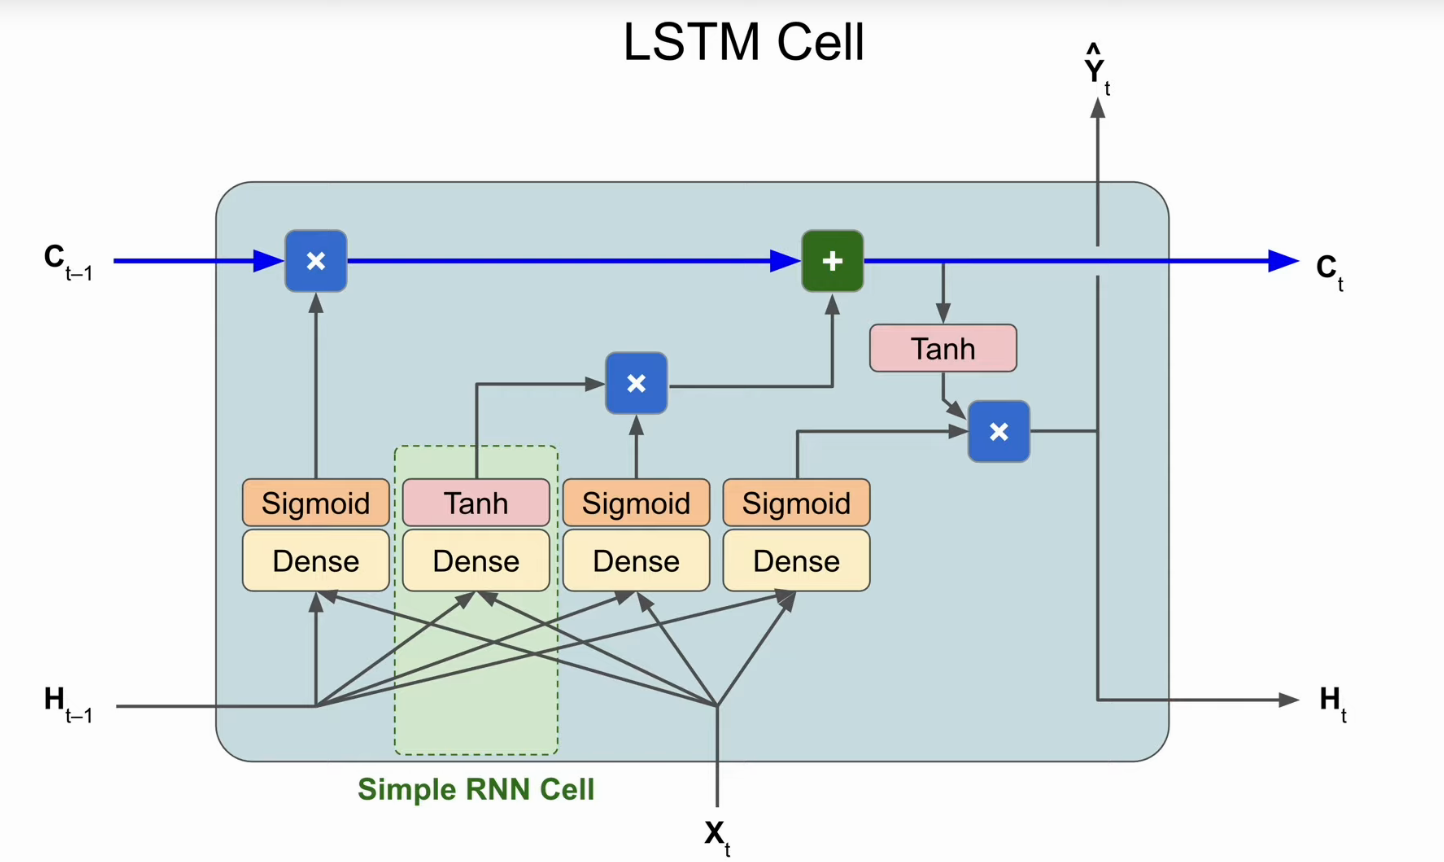
* Differently from the other types of cell, the LSTM can detect patterns of a hundred cells long

In [7]:
df = pd.read_csv("data/energydata_complete.csv")

In [8]:
ts = df["Appliances"]

In [9]:
ts.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [10]:
dates = pd.to_datetime(df.date)

In [11]:
series = np.asarray(ts.values)

In [12]:
time = np.arange(series.shape[0])

In [13]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [14]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 20000):
    dataset = tf.data.Dataset.from_tensor_slices(series) #instead of random values we are doing it with the data
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size = shuffle_buffer) #IID gd works best #buffersize must be greater or equal to the number of examples
    dataset = dataset.batch(batch_size).prefetch(1) # you probably will want bigger batchs like 32 / 64
    return dataset

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

In [17]:
split_time = int(series.shape[0] * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [20]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True) # we shift cause one start where other ends
    ds = ds.flat_map(lambda window: window.batch(window_size + 1)) # we dont shuffle cause we need in order
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [21]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1,None,1]), #batch with one window at time
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch/20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.Adam()

model.compile(loss=keras.losses.mean_squared_error,
             optimizer=optimizer,
             metrics=["mae","mse"])

history = model.fit(train_set, epochs=100,
                   callbacks=[lr_schedule, reset_states])

Epoch 1/100
526/526 [==============================] - 6s 12ms/step - loss: 34126.8622 - mae: 151.0688 - mse: 34126.8516
Epoch 2/100
526/526 [==============================] - 3s 6ms/step - loss: 33914.0529 - mae: 150.3600 - mse: 33914.0469
Epoch 3/100
526/526 [==============================] - 3s 5ms/step - loss: 33668.6527 - mae: 149.5381 - mse: 33668.6406
Epoch 4/100
526/526 [==============================] - 3s 6ms/step - loss: 33387.9147 - mae: 148.5923 - mse: 33387.8867
Epoch 5/100
526/526 [==============================] - 3s 6ms/step - loss: 33076.8983 - mae: 147.5379 - mse: 33076.9062
Epoch 6/100
526/526 [==============================] - 3s 5ms/step - loss: 32739.2459 - mae: 146.3848 - mse: 32739.2539
Epoch 7/100
526/526 [==============================] - 3s 6ms/step - loss: 32367.0266 - mae: 145.1023 - mse: 32367.0117
Epoch 8/100
526/526 [==============================] - 3s 5ms/step - loss: 31950.6651 - mae: 143.6539 - mse: 31950.6445
Epoch 9/100
526/526 [==================

526/526 [==============================] - 3s 5ms/step - loss: 4778.9750 - mae: 31.9910 - mse: 4778.9766
Epoch 70/100
526/526 [==============================] - 3s 5ms/step - loss: 4701.9352 - mae: 31.7263 - mse: 4701.9360
Epoch 71/100
526/526 [==============================] - 3s 5ms/step - loss: 4642.0749 - mae: 31.5783 - mse: 4642.0742
Epoch 72/100
526/526 [==============================] - 3s 5ms/step - loss: 4596.9257 - mae: 31.5336 - mse: 4596.9263
Epoch 73/100
526/526 [==============================] - 3s 5ms/step - loss: 4560.8834 - mae: 31.5044 - mse: 4560.8848
Epoch 74/100
526/526 [==============================] - 3s 5ms/step - loss: 4535.9518 - mae: 31.5431 - mse: 4535.9502
Epoch 75/100
526/526 [==============================] - 3s 5ms/step - loss: 4518.5051 - mae: 31.6043 - mse: 4518.5063
Epoch 76/100
526/526 [==============================] - 3s 5ms/step - loss: 4506.7528 - mae: 31.6500 - mse: 4506.7568
Epoch 77/100
526/526 [==============================] - 3s 5ms/step -

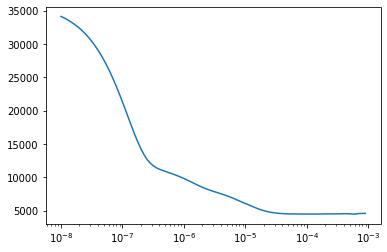

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
526/526 [==============================] - 5s 9ms/step - loss: 40.8062 - mae: 41.2991 - val_loss: 33.4562 - val_mae: 33.9509
Epoch 2/500
526/526 [==============================] - 3s 6ms/step - loss: 34.6103 - mae: 35.1020 - val_loss: 29.3833 - val_mae: 29.8769
Epoch 3/500
526/526 [==============================] - 3s 6ms/step - loss: 31.7161 - mae: 32.2064 - val_loss: 27.7376 - val_mae: 28.2314
Epoch 4/500
526/526 [==============================] - 3s 6ms/step - loss: 29.4769 - mae: 29.9672 - val_loss: 27.8252 - val_mae: 28.3217
Epoch 5/500
526/526 [==============================] - 3s 6ms/step - loss: 28.7151 - mae: 29.2050 - val_loss: 28.1456 - val_mae: 28.6406
Epoch 6/500
526/526 [==============================] - 3s 6ms/step - loss: 28.2471 - mae: 28.7371 - val_loss: 26.7883 - val_mae: 27.2831
Epoch 7/500
526/526 [==============================] - 3s 6ms/step - loss: 28.1184 - mae: 28.6070 - val_loss: 26.3304 - val_mae: 26.8244
Epoch 8/500
526/526 [====================

526/526 [==============================] - 3s 6ms/step - loss: 26.4944 - mae: 26.9821 - val_loss: 22.6151 - val_mae: 23.1026
Epoch 61/500
526/526 [==============================] - 3s 6ms/step - loss: 26.4539 - mae: 26.9417 - val_loss: 22.6118 - val_mae: 23.0993
Epoch 62/500
526/526 [==============================] - 3s 6ms/step - loss: 26.4620 - mae: 26.9500 - val_loss: 22.6687 - val_mae: 23.1547
Epoch 63/500
526/526 [==============================] - 3s 6ms/step - loss: 26.4337 - mae: 26.9217 - val_loss: 22.6066 - val_mae: 23.0936
Epoch 64/500
526/526 [==============================] - 3s 6ms/step - loss: 26.4051 - mae: 26.8928 - val_loss: 22.5980 - val_mae: 23.0846
Epoch 65/500
526/526 [==============================] - 3s 6ms/step - loss: 26.4103 - mae: 26.8983 - val_loss: 22.6486 - val_mae: 23.1335
Epoch 66/500
526/526 [==============================] - 3s 6ms/step - loss: 26.3852 - mae: 26.8730 - val_loss: 22.6640 - val_mae: 23.1488
Epoch 67/500
526/526 [=========================

526/526 [==============================] - 3s 6ms/step - loss: 25.4347 - mae: 25.9222 - val_loss: 22.2350 - val_mae: 22.7231
Epoch 120/500
526/526 [==============================] - 3s 6ms/step - loss: 25.4431 - mae: 25.9306 - val_loss: 22.2371 - val_mae: 22.7250
Epoch 121/500
526/526 [==============================] - 3s 6ms/step - loss: 25.5156 - mae: 26.0034 - val_loss: 22.2364 - val_mae: 22.7240
Epoch 122/500
526/526 [==============================] - 3s 6ms/step - loss: 25.4299 - mae: 25.9167 - val_loss: 22.2377 - val_mae: 22.7251
Epoch 123/500
526/526 [==============================] - 3s 6ms/step - loss: 25.4047 - mae: 25.8914 - val_loss: 22.1671 - val_mae: 22.6564
Epoch 124/500
526/526 [==============================] - 3s 6ms/step - loss: 25.3591 - mae: 25.8455 - val_loss: 22.1120 - val_mae: 22.6023
Epoch 125/500
526/526 [==============================] - 3s 6ms/step - loss: 25.3967 - mae: 25.8827 - val_loss: 22.1548 - val_mae: 22.6435
Epoch 126/500
526/526 [==================

In [25]:
model = keras.models.load_model("my_checkpoint_LSTM.h5")

In [26]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [27]:
rnn_forecast.shape

(3947,)

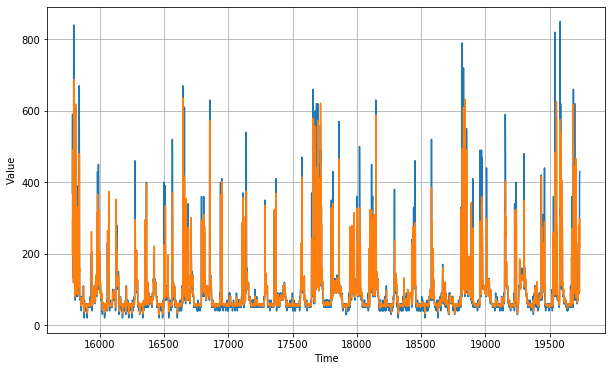

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [29]:
keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()

3362.4043

In [30]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

22.900827

* For far, the best one yet.